# **ANA 699 Thesis Code**
# **Project:  Early Detection of Alzheimer's Using Convolutional Neural Networks for MRI Scan Classification**
## Team CNN: Leticia Genao, Brashon Ford, Misato Nasu, Kevin Carrillo



## **Mount, Imports, Set File Paths**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img,ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
base_dir = '/content/drive/My Drive/ANA699/2.Data_Literature/Datasets'

print("Base directory contents:", os.listdir(base_dir))

Base directory contents: ['BRFSS 2022', 'ADNI', 'Oasis 1-2', 'oasis_subset_9488', 'alzheimers_imaging_dataset']


In [ ]:
alzheimers_train_dir = os.path.join(base_dir, 'alzheimers_imaging_dataset/train')
print("Alzheimer's Imaging Train directory contents:", os.listdir(alzheimers_train_dir))

alzheimers_test_dir = os.path.join(base_dir, 'alzheimers_imaging_dataset/test')
print("Alzheimer's Imaging Test directory contents:", os.listdir(alzheimers_test_dir))

oasis_dir = os.path.join(base_dir, 'oasis_subset_9488')
print("OASIS Subset directory contents:", os.listdir(oasis_dir))

Alzheimer's Imaging Train directory contents: ['.DS_Store', 'NonDemented', 'MildDemented', 'ModerateDemented', 'VeryMildDemented']
Alzheimer's Imaging Test directory contents: ['VeryMildDemented', 'NonDemented', 'MildDemented', 'ModerateDemented']
OASIS Subset directory contents: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']


# **TEAM NOTE: RAN OUT OF RAM**. Currently testing out code locally. We can chat about how to handle this. I'm looking into ImageDataGenerator to work in batches. If not, there's alternatives. - Leti

**RAM upgraded** 9/4/2024 - Kevin

## **Loading Images and Labels**

In [ ]:
def load_images_from_folder(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

def load_dataset(base_path, labels_dict, img_size=(128, 128)):
    images = []
    labels = []
    for folder_name, label in labels_dict.items():
        folder_path = os.path.join(base_path, folder_name)
        imgs, lbls = load_images_from_folder(folder_path, label, img_size)
        images.extend(imgs)
        labels.extend(lbls)
    return np.array(images), np.array(labels)

In [ ]:
alzheimers_imaging_labels = {
    'VeryMildDemented': 0,
    'ModerateDemented': 1,
    'MildDemented': 2,
    'NonDemented': 3
}

oasis_subset_labels = {
    'Moderate Dementia': 1,
    'Mild Dementia': 2,
    'Non Demented': 3,
    'Very mild Dementia': 0
}

In [ ]:
alzheimers_train_images, alzheimers_train_labels = load_dataset(alzheimers_train_dir, alzheimers_imaging_labels)

In [ ]:
oasis_images, oasis_labels = load_dataset(oasis_dir, oasis_subset_labels)

## **Checking the Datasets**

In [ ]:
def check_dataset(images, labels, dataset_name):
    print(f"{dataset_name} - Images shape: {images.shape}, Labels shape: {labels.shape}")
    print(f"{dataset_name} - Unique labels: {np.unique(labels)}")

check_dataset(alzheimers_train_images, alzheimers_train_labels, "Alzheimer's Imaging Train")
check_dataset(alzheimers_test_images, alzheimers_test_labels, "Alzheimer's Imaging Test")
check_dataset(oasis_images, oasis_labels, "OASIS Subset")

Alzheimer's Imaging Train - Images shape: (5121, 128, 128, 3), Labels shape: (5121,)
Alzheimer's Imaging Train - Unique labels: [0 1 2 3]
Alzheimer's Imaging Test - Images shape: (1279, 128, 128, 3), Labels shape: (1279,)
Alzheimer's Imaging Test - Unique labels: [0 1 2 3]
OASIS Subset - Images shape: (9488, 128, 128, 3), Labels shape: (9488,)
OASIS Subset - Unique labels: [0 1 2 3]


# **Combining the Datasets**

In [ ]:
combined_images = np.concatenate((alzheimers_train_images, oasis_images), axis=0)

combined_labels = np.concatenate((alzheimers_train_labels, oasis_labels), axis=0)

print(f"Combined Images shape: {combined_images.shape}")
print(f"Combined Labels shape: {combined_labels.shape}")
print(f"Unique labels in combined dataset: {np.unique(combined_labels)}")

Combined Images shape: (14609, 128, 128, 3)
Combined Labels shape: (14609,)
Unique labels in combined dataset: [0 1 2 3]


In [ ]:
label_mapping = {
    0: 'Very Mild Demented',
    1: 'Moderate Demented',
    2: 'Mild Demented',
    3: 'Non Demented'
}

label_counts = np.bincount(combined_labels)

df_label_counts = pd.DataFrame({
    'Label': np.arange(len(label_counts)),
    'Label Name': [label_mapping[i] for i in range(len(label_counts))],
    'Count of Images': label_counts
})

print(df_label_counts)


   Label          Label Name  Count of Images
0      0  Very Mild Demented             4792
1      1   Moderate Demented              540
2      2       Mild Demented             3717
3      3        Non Demented             5560


# **Build, Train, and Test the CNN Model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5493 - loss: 0.9429 - val_accuracy: 0.8415 - val_loss: 0.3426
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8390 - loss: 0.3569 - val_accuracy: 0.8840 - val_loss: 0.2548
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8755 - loss: 0.2700 - val_accuracy: 0.9168 - val_loss: 0.1942
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8980 - loss: 0.2297 - val_accuracy: 0.9220 - val_loss: 0.1762
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9222 - loss: 0.1776 - val_accuracy: 0.9603 - val_loss: 0.1153
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9363 - loss: 0.1532 - val_accuracy: 0.9661 - val_loss: 0.0900
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9559 - loss: 0.1084 - val_accuracy: 0.9473 - val_loss: 0.1592
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9598 - loss: 0.1071 - val_acc

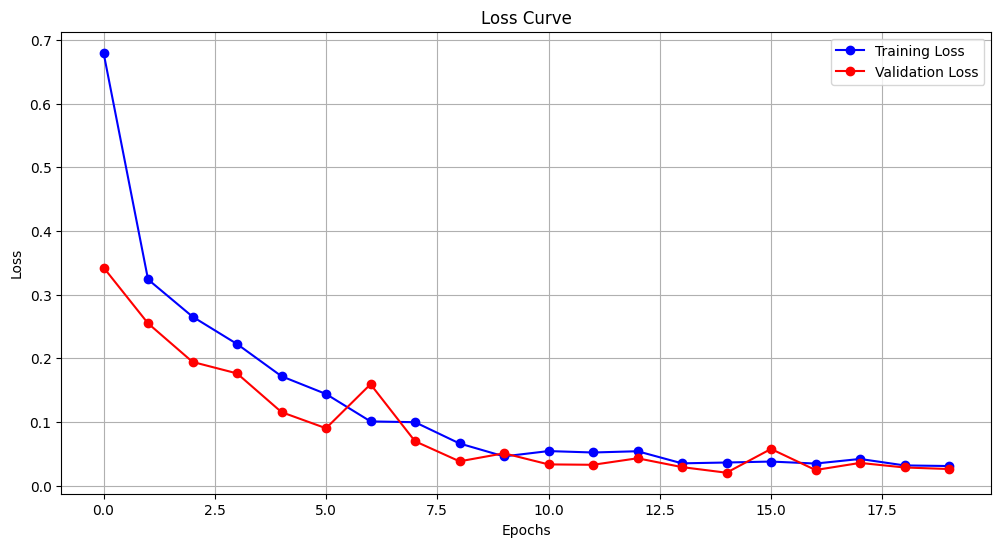

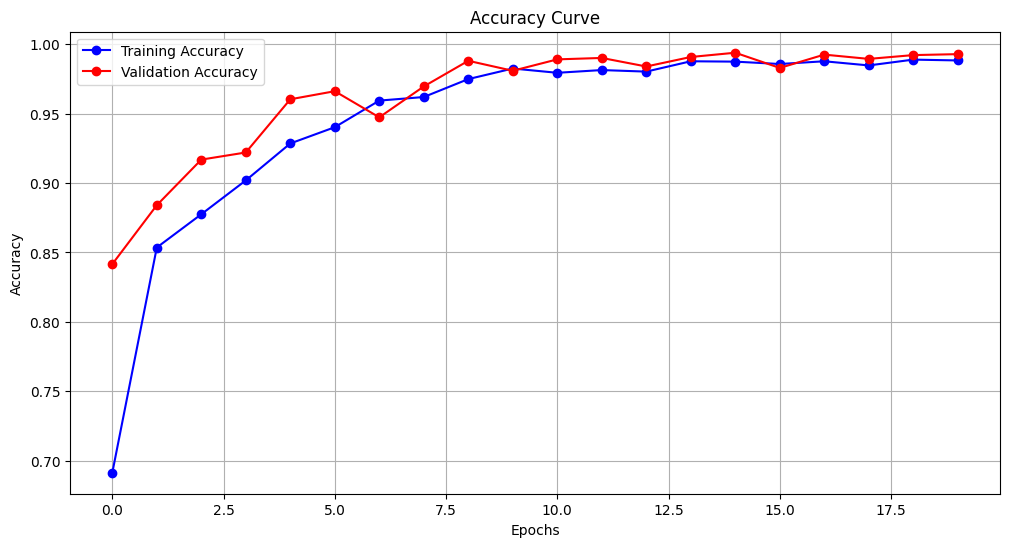

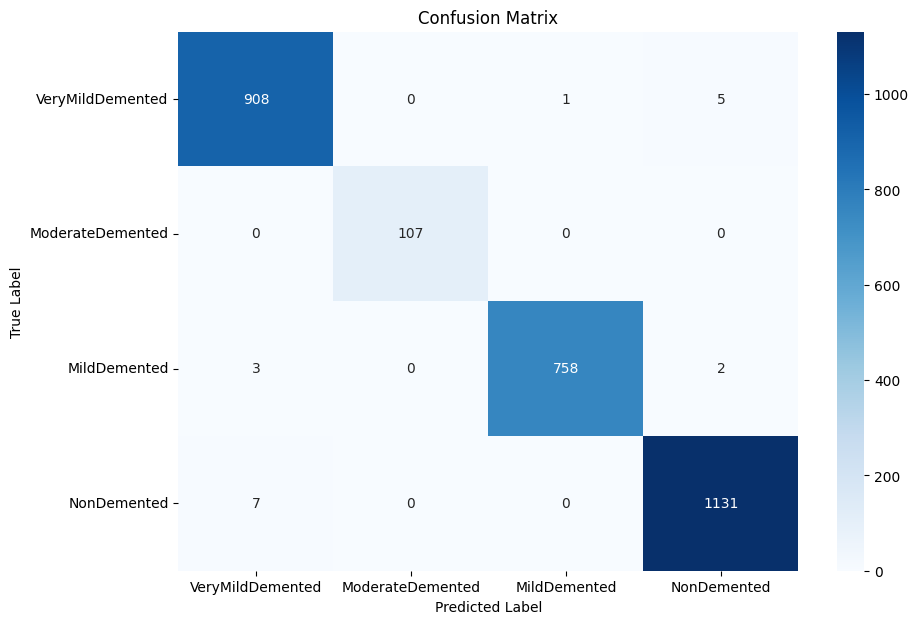

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle


combined_images = combined_images.astype('float32') / 255.0

combined_labels = to_categorical(combined_labels, num_classes=4)

combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_report = classification_report(y_true, y_pred, target_names=['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'])
print("Classification Report:\n", class_report)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'],
            yticklabels=['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



Greater validation accuracy here finishing with a 98.94% accuracy.

# **Now to create and train the SVM model**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X_flat = combined_images.reshape(14609, -1)

In [ ]:
X_flat = X_flat / 255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, combined_labels, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97       940
     Class 1       1.00      0.99      0.99        94
     Class 2       1.00      0.96      0.98       755
     Class 3       0.96      1.00      0.98      1133

    accuracy                           0.97      2922
   macro avg       0.98      0.98      0.98      2922
weighted avg       0.98      0.97      0.97      2922



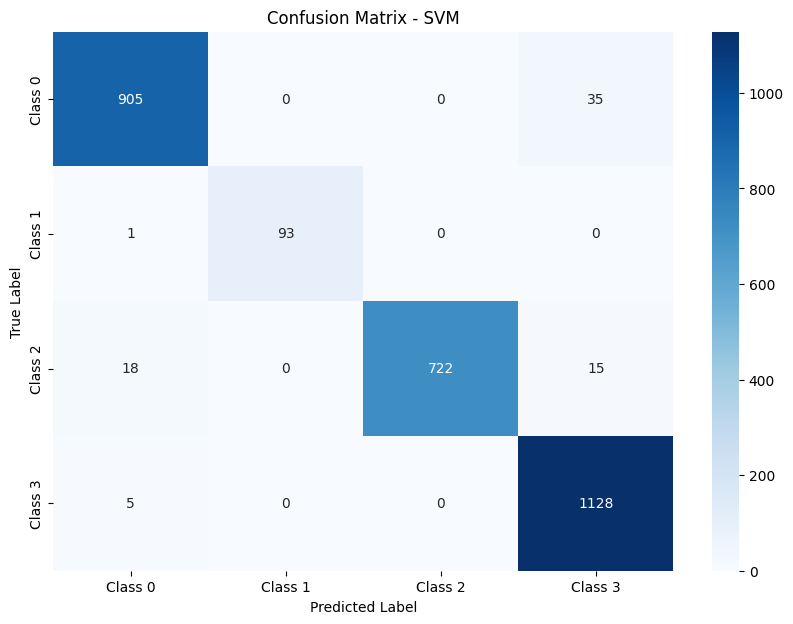

In [ ]:
y_pred_svm = svm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']))

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

